In [2]:
### Distributed Glowworm Optimization Scheme
### Wiki: https://en.wikipedia.org/wiki/Glowworm_swarm_optimization
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
import simpy

In [60]:
##############################################################################
# GSO PARAMETERS 
##############################################################################
dims = 1000
num_worms = 25
nturns = 2000
lower_bound = 70
influence_factor = 30
max_jitter = 0.2

In [61]:
##############################################################################
# Fitness Function 
##############################################################################
def fitness_function(xy_tuple):
    x = xy_tuple[0]/200
    y = xy_tuple[1]/200
    return np.cos(x) * np.cos(y) * np.exp(-((x - np.pi)**2 + (y - np.pi)**2))

In [62]:
##############################################################################
# Keep the swarm do not go beyond the boundary
##############################################################################
def keep_in_bounds(x, dims):
    if x < 0:
        return 0
    elif x > dims:
        return dims
    else:
        return x

In [63]:
"""
Compute the polar coordinates of (x1, y1) relative to (x2, y2).

Parameters
----------
(x1, y1) : numpy tuple of float
    Coordinates of the target point.
(x2, y2) : numpy tuple of float
    Coordinates of the reference point.

Returns
-------
(r, theta) : numpy tuple of floats
    r is the distance from (x1, y1) to (x2, y2).
    theta is the angle (in radians) from the positive x-axis.
"""

def to_relative_polar(x1, x2):
    dx = x1[0] - x2[0]
    dy = x1[1] - x2[1]
    
    r = np.sqrt(dx**2 + dy**2)      # Radial distance
    theta = np.arctan2(dy, dx)       # Angle in radians

    polar = np.array([r, theta])
    
    return polar

"""
Compute the cartesian coordinate of (x1, y1) when polar coordinate and cartesian coordinate of (x2, y2) are given.

Parameters
----------
(r, theta) : numpy tuple of floats
    r is the distance from (x1, y1) to (x2, y2).
    theta is the angle (in radians) from the positive x-axis.
(x2, y2) : numpy tuple of float
    Coordinates of the reference point.

Returns
-------
(x1, y1) : numpy tuple of float
    Coordinates of the target point.
"""

def to_cartesian(polar, x2):
    dx = x2[0] + np.cos(polar[1]) * polar[0]
    dy = x2[1] + np.sin(polar[1]) * polar[0]

    x1 = np.array([dx, dy])
    
    return x1

In [ ]:
##############################################################################
# GSO FUNCTIONS 
##############################################################################
class Glowworm:
    def __init__(self, env, name, swarm, X=np.array([1, 1]), waypoint = np.array([1, 1]),  speed=1.5433, 
                 transRange=200, score = 0.0):
        self.env = env
        self.name = name
        self.swarm = swarm  # List of all particles
        self.transmission_range = transRange
        self.speed = speed # 0.015433 -> 3 knots
        self.waypoint = waypoint

        self.X = X
        self.V = np.random.randn(2) * 0.1
        #self.nextWaypoint = X
        self.score = score # for transmisstion distance
        self.influenceDict = {name: {'distance':0.0, 'angle':0.0, 'score':0.0}} # name: distance, angle, score

        self.positions = [self.X.copy()]
        self.process = env.process(self.run())
    
    # class Glowworm_Info:
    #     def __init__(self,name,angle,distance,score):
    #         self.name = name
    #         self.angle = angle
    #         self.distance = distance
    #         self.score = score

    def sensing(self): # 
        """accquire the fitness of worm's current position to calculate 'influence radius'."""
        shifted = fitness_function(self.X) + lower_bound
        self.score = shifted / influence_factor

    def send(self):
        """If worm j is within worm j's radius, record distance; else 0. For influence martrix"""
        for glowworm in self.swarm:
            distance =  np.linalg.norm(self.X-glowworm.X)
            if distance <= self.transmission_range: # Changed from self.score
                if glowworm.name == self.name:
                    self.influenceDict[self.name] = {'distance':0.0, 'angle':0.0, 'score':0.0}
                else:
                    polar_cor = to_relative_polar(self.X, glowworm.X)
                    glowworm.receive(self.name, self.score, polar_cor) 

    # def signalSourceLocalization(self,wormName):
    #     """measure the distance and angle between worm and self"""
    #     wormPosition = np.array([0.0,0.0])
    #     for i in self.swarm:
    #         if i.name == wormName:
    #             wormPosition[0] = i.X[0]
    #             wormPosition[1] = i.X[1]
    #     return to_relative_polar(wormPosition, self.X)

    def receive(self, worm_name, worm_score, polar_cor):
        """update the influenceDict"""
        self.influenceDict[worm_name] = {'distance':polar_cor[0], 'angle':polar_cor[1], 'score':worm_score}

    def update(self):
        """Update each worm's position based on the dict of influences."""
        new_position = np.array([0.0, 0.0])
        x_move = 0.0
        y_move = 0.0
        for glowworm_name in self.influenceDict:
            glowworm_score = self.influenceDict[glowworm_name]['score']
            glowworm_angle = self.influenceDict[glowworm_name]['angle']
            glowworm_distance = self.influenceDict[glowworm_name]['distance']
            if glowworm_distance != 0 and self.score < glowworm_score:
                percent_move = 1 - (glowworm_distance / glowworm_score)
                # x_move += (glowworm.X[0] - self.X[0]) * percent_move / 10
                # y_move += (glowworm.X[1] - self.X[1]) * percent_move / 10
                x_move += (np.cos(glowworm_angle) * glowworm_distance) * percent_move / 10
                y_move += (np.sin(glowworm_angle) * glowworm_distance) * percent_move / 10
        
        # Add random jitter
        jitter_x = max_jitter * np.random.rand() * np.random.randint(-1,2)
        jitter_y = max_jitter * np.random.rand() * np.random.randint(-1,2)
        
        new_position[0] = self.X[0] + x_move + jitter_x
        new_position[1] = self.X[1] + y_move + jitter_y
        
        # Bound checking
        new_position[0] = keep_in_bounds(new_position[0], dims)
        new_position[1] = keep_in_bounds(new_position[1], dims)

        self.waypoint = new_position

        print(self.name, self.waypoint)

    def move(self):
        direction = self.waypoint-self.X
        self.X = self.X + self.speed * (direction / np.linalg.norm(direction))
        distance = np.linalg.norm(self.X - self.waypoint) # Euclidean distance
        if distance <= 3:  # Interaction threshold
            self.update()

    ##############################################################################
    # SIMPY INTEGRATION
    ##############################################################################
    def run(self):
        """
        A generator (process) that runs GSO for 'nturns' iterations in a SimPy environment.
        Each iteration is considered one time-step in the simulation.
        """
        i = 0
        while True:
            # Compute glowworm logic
            self.sensing()
            self.send()
            self.move()

            # Store positions for later analysis or plotting
            if i % 10 == 0:    
                self.positions.append(self.X.copy()) # take the records of position
            i = i + 1

            # Advance simulated time by 1 time unit
            yield self.env.timeout(1)


In [65]:
# def starting_points(num_worms):
#     """Initialize the worm positions randomly."""
#     return np.random.rand(num_worms, 2) * dims

def starting_points(num_worms):
    """Evenly distribute particles on a grid within the search space."""
    list_glowworm = []
    start = 0.1 * dims
    end = 0.9 * dims
    
    # Determine the number of rows and columns based on the number of particles
    n_side = int(np.ceil(np.sqrt(num_worms)))  # Number of rows and columns in the grid
    x_coords = np.linspace(start, end, n_side)
    y_coords = np.linspace(start, end, n_side)

    # Create particles and assign grid positions
    for i in range(num_worms):
        # Calculate grid coordinates (i.e., row and column)
        row = i // n_side
        col = i % n_side
        grid_position = np.array([x_coords[col], y_coords[row]])  # Assign grid position
        list_glowworm.append(grid_position)
    
    return np.array(list_glowworm)

In [66]:
def run_gso_simpy():
    """
    Sets up the SimPy environment, runs the glowworm process,
    and returns the recorded positions.
    """
    sim_env = simpy.Environment()

    # Initial population
    pop = starting_points(num_worms)

    # x, y = np.array(np.meshgrid(np.linspace(0, 500, 5000), np.linspace(0, 500, 5000)))
    # z = fitness_function([x, y])
    # x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]
    # target_position = np.array([x_min, y_min])  # Define the target position
    # target_fitness = fitness_function([x_min, y_min])

    # Create and start the GSO process
    swarm = []    
    for i in range(num_worms):
        swarm.append(Glowworm(env = sim_env, name = i, swarm = [], X=pop[i], waypoint = pop[i]+np.random.uniform(-50, 50, size=2)))

    for glowworm in swarm:
        glowworm.swarm = swarm  # Give each glowworm the list of all glowworm
        #particle.target = [target_position,target_fitness]

    # Run the simulation
    sim_env.run(until=nturns)

    swarm_positions = []
    for glowworm in swarm:
        swarm_positions.append(glowworm.positions)

    return swarm_positions

In [67]:
##############################################################################
# MAIN (Demo)
##############################################################################
if __name__ == "__main__":
    all_positions = run_gso_simpy()

18 [705.07738703 682.52374832]
11 [282.52026946 508.44744092]
3 [698.37625925 120.18425398]
7 [485.46610666 320.34083327]
12 [474.73834228 499.68281914]
15 [101.14474185 724.97035716]
1 [316.77527221 121.9317154 ]
8 [720.86022737 283.97412248]
14 [902.72462997 467.41547205]
16 [267.69973528 707.64790562]
22 [467.27170834 899.49188424]
2 [502.79796314 136.16981522]
5 [116.50376165 332.34033235]
13 [728.58899164 478.07087715]
4 [913.15221333 134.59676051]
4 [912.48153652 133.14033172]
21 [315.99722074 863.1114537 ]
23 [673.42302323 930.12305746]
20 [104.65835478 941.89170378]
20 [104.43465245 939.77607727]
19 [914.57539235 656.96491558]
24 [856.22718335 883.72714686]
6 [336.25141233 335.33997661]
10 [ 81.1198458  453.91684401]
15 [ 90.60770566 750.9980382 ]
9 [854.13665817 263.40938304]
0 [ 58.99137413 148.47328395]
17 [542.33133456 650.73400447]
17 [541.38008157 652.00758709]
17 [542.59324571 651.86314482]
17 [541.67816658 651.1513008 ]
17 [542.80664177 651.95222032]
19 [1000.          

C:\Users\byang12\AppData\Local\Temp\ipykernel_10656\189924935.py:92: RuntimeWarning: invalid value encountered in divide
  self.X = self.X + self.speed * (direction / np.linalg.norm(direction))


0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
3 [1000.          118.42570003]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
9 [1000.          495.10799781]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
7 [544.20964817   0.        ]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
0 [0. 0.]
23 [1000. 1000.]
0 [0. 0.]
23 [1000. 1000.]
0 [0. 0.]
23 [1000. 1000.]
0 [0. 0.]
23 [1000. 1000.]
0 [0. 0.]
23 [1000. 1000.]
0 [0. 0.]
23 [1000. 1000.]
0 [0. 0.]
23 [1000. 1000.]
0 [0. 0.]
23 [1000. 1000.]
0 [0. 0.]
23 [1000. 1000.]
0 [0. 0.]
23 [1000. 1000.]
0 [0. 0.]
23 [1000. 1000.]
0 [0. 0.]
23 [1000. 1000.]
0 [0. 0.]
23

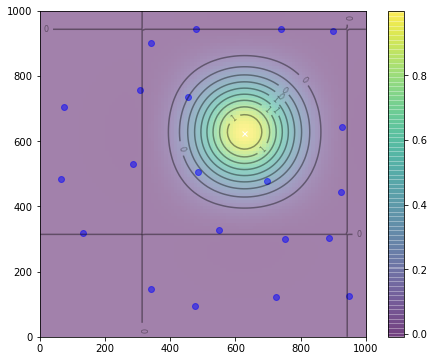

In [46]:
# Plotting - no Animation
x, y = np.array(np.meshgrid(np.linspace(0, dims, 100), np.linspace(0, dims, 100)))
z = fitness_function([x, y])
x_max, y_max = x.ravel()[z.argmax()], y.ravel()[z.argmax()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, dims, 0, dims], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_max], [y_max], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
#p_plot = ax.scatter(positions[0][0], positions[0][1], marker='o', color='blue', alpha=0.5)
#nbest_plot = plt.scatter([nbest[0]], [nbest[1]], marker='*', s=100, color='black', alpha=0.4)

i = 5
ax.clear()
ax.imshow(z, extent=[0, dims, 0, dims], origin='lower', cmap='viridis', alpha=0.5)
ax.plot([x_max], [y_max], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
x_list = []
y_list = []
for j in range(num_worms):
    x_list.append(all_positions[j][i][0])
    y_list.append(all_positions[j][i][1])
p_plot = ax.scatter(x_list, y_list, marker='o', color='blue', alpha=0.5)
#nbest_plot.set_offsets(nbest.reshape(1, -1))
plt.show()